## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
* Brief overview of the task.
* Description of the dataset used for analysis.

Overview of the Task

For this homework assignment, I focused on creating a sentiment analysis model using an LSTM network to classify movie reviews as either positive or negative. Sentiment analysis is really important because it helps us extract meaningful insights from text data. This can be applied to things like opinion mining, evaluating customer feedback, and improving recommendation systems.

Description of the Dataset Used for Analysis

I used a dataset named subset-10000_IMDB_Dataset.csv, which contains 10,000 movie reviews from the Internet Movie Database (IMDB). The dataset is perfectly balanced with 5,000 positive reviews and 5,000 negative reviews. This balance ensures that the model doesn't become biased during training or testing.

In [42]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
file_path = "/content/subset10000_IMDB_Dataset.csv"
data = pd.read_csv(file_path)

print("First 5 rows of the dataset:")
print(data.head())

data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

print("\nAfter mapping sentiments to numerical form:")
print(data.head())

First 5 rows of the dataset:
                                              review sentiment
0  Starts really well, nice intro and build up fo...  negative
1  Terrific movie: If you did not watch yet, you ...  positive
2  I've seen hundreds of silent movies. Some will...  positive
3  i had been looking for this film for so long b...  positive
4  Good: Engaging cinematic firefights, great pre...  positive

After mapping sentiments to numerical form:
                                              review  sentiment
0  Starts really well, nice intro and build up fo...          0
1  Terrific movie: If you did not watch yet, you ...          1
2  I've seen hundreds of silent movies. Some will...          1
3  i had been looking for this film for so long b...          1
4  Good: Engaging cinematic firefights, great pre...          1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Missing Values in Each Column:
review       0
sentiment    0
dtype: int64

Statistical Summary of Numerical Columns:
          sentiment
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

Class Distribution:
sentiment
0    5000
1    5000
Name: count, dtype: int64


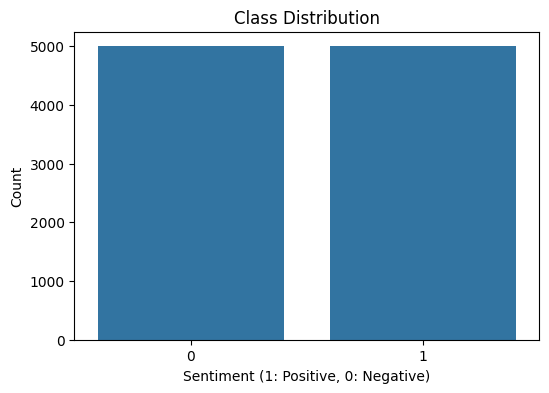

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nDataset Information:")
print(data.info())

print("\nMissing Values in Each Column:")
print(data.isnull().sum())

print("\nStatistical Summary of Numerical Columns:")
print(data.describe())

print("\nClass Distribution:")
print(data['sentiment'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='sentiment')
plt.title('Class Distribution')
plt.xlabel('Sentiment (1: Positive, 0: Negative)')
plt.ylabel('Count')
plt.show()

### 2. Preprocessing the Data (10 points)

In [45]:

def preprocess_text(text):
    text = re.sub(r"[/\-]", " ", text)

    text = re.sub(r"<.*?>", " ", text)

    text = text.lower()

    text = re.sub(r"[^a-z\s]", "", text)

    tokens = [word for word in text.split() if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

data['tokens'] = data['review'].apply(preprocess_text)

print("Data with preprocessed tokens:")
print(data[['review', 'tokens']].head())

Data with preprocessed tokens:
                                              review  \
0  Starts really well, nice intro and build up fo...   
1  Terrific movie: If you did not watch yet, you ...   
2  I've seen hundreds of silent movies. Some will...   
3  i had been looking for this film for so long b...   
4  Good: Engaging cinematic firefights, great pre...   

                                              tokens  
0  [start, really, well, nice, intro, build, main...  
1  [terrific, movie, watch, yet, must, watch, gee...  
2  [ive, seen, hundred, silent, movie, always, cl...  
3  [looking, film, long, found, seen, younger, lo...  
4  [good, engaging, cinematic, firefights, great,...  


In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tokens'])

data['token_indices'] = tokenizer.texts_to_sequences(data['tokens'])

vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary Size: {vocab_size}")


Vocabulary Size: 53392



Review Length Statistics:
count    10000.000000
mean       120.059200
std         90.808784
min          4.000000
25%         64.000000
50%         89.000000
75%        148.000000
max        818.000000
Name: review_length, dtype: float64


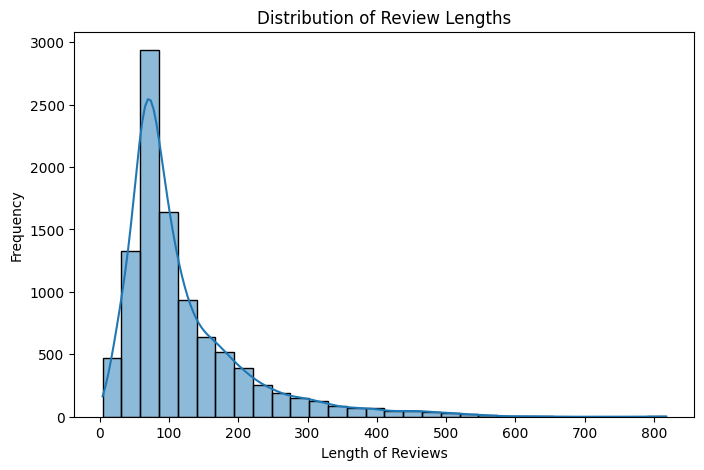

Padding all reviews to length: 150


In [47]:
data['review_length'] = data['token_indices'].apply(len)

print("\nReview Length Statistics:")
print(data['review_length'].describe())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()

MAX_LEN = 150
print(f"Padding all reviews to length: {MAX_LEN}")

In [48]:
def pad_sequence(seq, max_len):
    return pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

data['padded_indices'] = list(pad_sequence(data['token_indices'], MAX_LEN))

print("Padded sequences example:")
print(data['padded_indices'].iloc[0])

Padded sequences example:
[  140    14    16   230  4602  1152   183     6    93  1047   359     6
 14614   183  1325   149  3083  2215   114   643    87  3508   568    27
  3083     1  1356   866   158  1021 22416    43    92   235  1947  1906
 13213    39  6413    36   119    11  2413     1  8648   114   932   715
  3186   568 12100  1178   181   624    53   624   113  9719   502   692
     3   111  1617   703  1137   770    14    14    78   244  1338    33
     8   357   103   499  3956   206   219    30     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


### 3. Visualzing Word Vectors (15 points)

In [49]:
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [50]:
oov_words = [word for word in tokenizer.word_index if word not in fasttext_vectors]
oov_percentage = (len(oov_words) / len(tokenizer.word_index)) * 100

print(f"Number of Out-of-Vocabulary (OOV) words: {len(oov_words)}")
print(f"Percentage of OOV words: {oov_percentage:.2f}%")

if oov_percentage > 10:
    print("High OOV rate! This may negatively impact model performance.")
    print("Consider handling OOV words with random embeddings or expanding your embedding coverage.")
else:
    print("Low OOV rate. Most words have embeddings, which should help model performance.")

Number of Out-of-Vocabulary (OOV) words: 18516
Percentage of OOV words: 34.68%
High OOV rate! This may negatively impact model performance.
Consider handling OOV words with random embeddings or expanding your embedding coverage.


In [51]:
import nltk
from nltk.corpus import opinion_lexicon

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

print(f"Number of positive words: {len(positive_words)}")
print(f"Number of negative words: {len(negative_words)}")


sentiment_words = []

for word, count in tokenizer.word_counts.items():
    if word in positive_words or word in negative_words:
        if word in fasttext_vectors:
            sentiment_words.append((word, count))

sentiment_words = sorted(sentiment_words, key=lambda x: x[1], reverse=True)

selected_words = [word for word, count in sentiment_words[:100]]

print(f"Selected {len(selected_words)} sentiment-rich words for visualization.")
print("Example selected words:", selected_words[:10])

Number of positive words: 2006
Number of negative words: 4783
Selected 100 sentiment-rich words for visualization.
Example selected words: ['like', 'good', 'well', 'bad', 'great', 'love', 'plot', 'best', 'better', 'work']


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [52]:
import numpy as np

word_vectors = np.array([fasttext_vectors[word] for word in selected_words])
print(len(word_vectors))
print(f"Shape of word vectors: {word_vectors.shape}")

100
Shape of word vectors: (100, 300)


In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

print(f"Shape of reduced word vectors (2D): {word_vectors_2d.shape}")

Shape of reduced word vectors (2D): (100, 2)


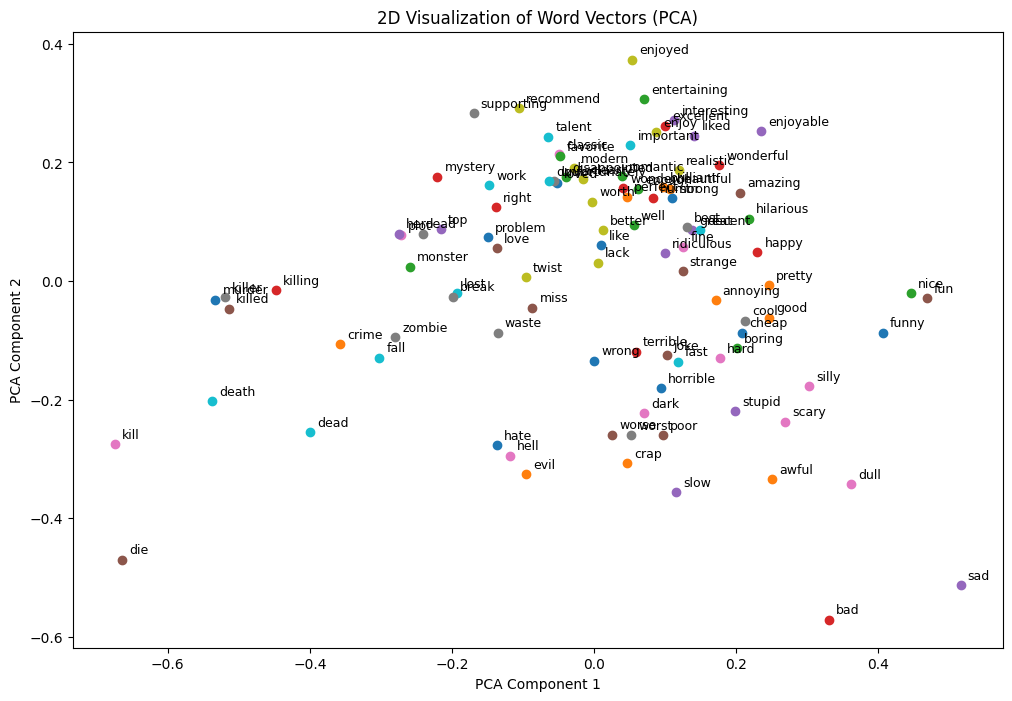

In [54]:
import matplotlib.pyplot as plt

# 2D Scatter plot

plt.figure(figsize=(12, 8))
for i, word in enumerate(selected_words):
    x, y = word_vectors_2d[i, 0], word_vectors_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)
plt.title("2D Visualization of Word Vectors (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

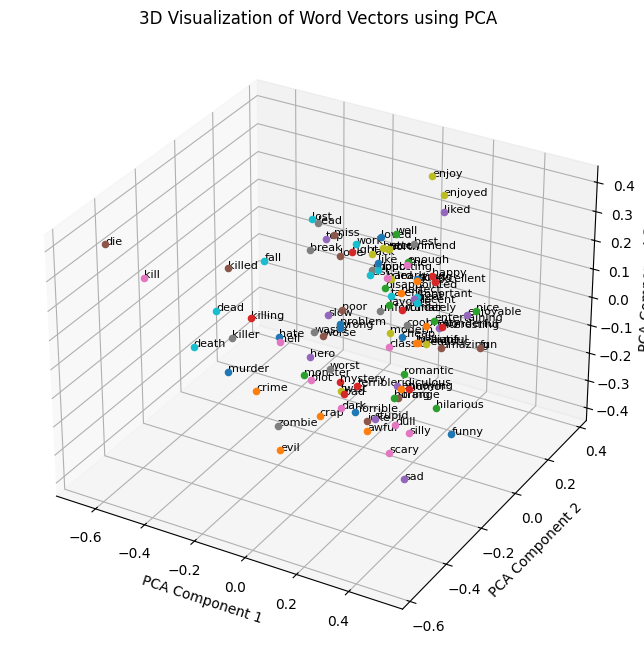

In [55]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
word_vectors_3d = pca_3d.fit_transform(word_vectors)

# 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(selected_words):
    ax.scatter(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2])
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word, fontsize=8)

ax.set_title("3D Visualization of Word Vectors using PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()

### 4. Creating the Emebdding Matrix (10 points)

In [56]:
import numpy as np

def create_embedding_matrix(word2vec, vocab, embedding_dim):
    vocab_size = len(vocab) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    print(f"Embedding matrix created with shape: {embedding_matrix.shape}")
    return embedding_matrix

In [57]:
import torch
import torch.nn as nn

embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_vectors, tokenizer.word_index, embedding_dim)

embedding_tensor = torch.FloatTensor(embedding_matrix)

embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)

print("Embedding layer created using pre-trained embeddings.")
print(f"Embedding layer shape: {embedding_layer.weight.shape}")

Embedding matrix created with shape: (53392, 100)
Embedding layer created using pre-trained embeddings.
Embedding layer shape: torch.Size([53392, 100])


### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [58]:
from sklearn.model_selection import train_test_split

train_data, temp_data, train_labels, temp_labels = train_test_split(
    data['padded_indices'], data['sentiment'], test_size=0.3, random_state=42)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 7000
Validation data size: 1500
Test data size: 1500


In [59]:
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences.iloc[idx], dtype=torch.long)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return {
            'sequence': sequence,
            'label': label
        }


In [60]:
from torch.utils.data import DataLoader

train_dataset = IMDBDataset(train_data, train_labels)
val_dataset = IMDBDataset(val_data, val_labels)
test_dataset = IMDBDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully.")

DataLoaders created successfully.


### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [61]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.5):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size

        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.candidate_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout_prob)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)

        combined = self.dropout(combined)

        f_t = self.sigmoid(self.forget_gate(combined))

        i_t = self.sigmoid(self.input_gate(combined))

        c_t_candidate = self.tanh(self.candidate_gate(combined))

        c_t = (f_t * c_prev) + (i_t * c_t_candidate)

        o_t = self.sigmoid(self.output_gate(combined))

        h_t = o_t * self.tanh(c_t)

        return h_t, c_t


In [62]:
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):

        batch_size, seq_len, _ = x.size()

        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        outputs = []
        for t in range(seq_len):
            h_t, c_t = self.cell(x[:, t, :], h_t, c_t)
            outputs.append(h_t)

        outputs = torch.stack(outputs, dim=1)
        return outputs


In [63]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_matrix,
                 num_layers=2, dropout_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.dropout_emb = nn.Dropout(dropout_prob)

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob,
            batch_first=True
        )

        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout_emb(embedded)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden_state = hidden[-1]
        normalized = self.batch_norm(last_hidden_state)
        dropped_out = self.dropout(normalized)
        fc_out = self.fc(dropped_out)
        output = self.sigmoid(fc_out)
        return output


In [64]:
input_size = 100  # Word vector size
hidden_size = 128  # LSTM hidden size
output_size = 1  # Binary classification
batch_size = 32
learning_rate = 0.001
epochs = 50


In [65]:
criterion = nn.BCELoss()

model = SentimentLSTM(input_size, hidden_size, output_size, embedding_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [66]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience = 5
    wait = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['sequence'].to(device)
                labels = batch['label'].to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")



        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)


Epoch 1/50, Train Loss: 0.7391, Val Loss: 0.6948
Epoch 2/50, Train Loss: 0.7025, Val Loss: 0.6951
Epoch 3/50, Train Loss: 0.6947, Val Loss: 0.7019
Epoch 4/50, Train Loss: 0.6892, Val Loss: 0.7012
Epoch 5/50, Train Loss: 0.6805, Val Loss: 0.6957
Epoch 6/50, Train Loss: 0.6570, Val Loss: 0.6955
Epoch 7/50, Train Loss: 0.6978, Val Loss: 0.6974
Epoch 8/50, Train Loss: 0.6745, Val Loss: 4.4502
Epoch 9/50, Train Loss: 0.4806, Val Loss: 0.4390
Epoch 10/50, Train Loss: 0.2610, Val Loss: 1.2583
Epoch 11/50, Train Loss: 0.1758, Val Loss: 0.4643
Epoch 12/50, Train Loss: 0.1420, Val Loss: 0.3650
Epoch 13/50, Train Loss: 0.1041, Val Loss: 1.2206
Epoch 14/50, Train Loss: 0.0858, Val Loss: 0.5175
Epoch 15/50, Train Loss: 0.0737, Val Loss: 0.8001
Epoch 16/50, Train Loss: 0.0764, Val Loss: 0.6441
Epoch 17/50, Train Loss: 0.0682, Val Loss: 0.5442
Epoch 18/50, Train Loss: 0.0558, Val Loss: 1.6052
Epoch 19/50, Train Loss: 0.0585, Val Loss: 0.5947
Epoch 20/50, Train Loss: 0.0543, Val Loss: 0.6969
Epoch 21/

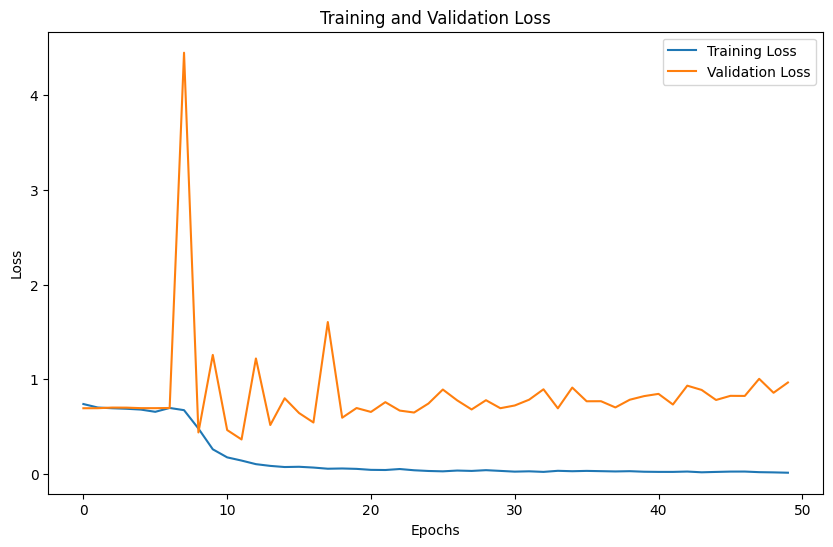

In [67]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
plot_training_history(train_losses, val_losses)

### 7. Testing and Analysis (15 points)

In [68]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_best_model_on_test_set(best_model_path, model, test_loader, criterion,
                                    train_metrics=None, val_metrics=None):

    model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            predictions = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)

    all_labels = [int(label[0]) for label in all_labels]
    all_predictions = [int(pred[0]) for pred in all_predictions]

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print("\n==================== Test Set Evaluation ====================")
    if train_metrics is not None and val_metrics is not None:
        print("Training Metrics:")
        for k, v in train_metrics.items():
            print(f"  {k}: {v:.4f}")
        print("\nValidation Metrics:")
        for k, v in val_metrics.items():
            print(f"  {k}: {v:.4f}")
    print("\nTest Performance:")
    print(f"  Test Loss:    {avg_test_loss:.4f}")
    print(f"  Accuracy:     {accuracy * 100:.2f}%")
    print(f"  Precision:    {precision * 100:.2f}%")
    print(f"  Recall:       {recall * 100:.2f}%")
    print(f"  F1-Score:     {f1 * 100:.2f}%")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print("============================================================\n")

    metrics = {
        'test_loss': avg_test_loss,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1_score': f1,
        'test_confusion_matrix': conf_matrix
    }
    return metrics

test_metrics = evaluate_best_model_on_test_set("best_model.pt", model, test_loader, criterion,
)


==================== Test Set Evaluation ====================

Test Performance:
  Test Loss:    0.3867
  Accuracy:     84.40%
  Precision:    83.42%
  Recall:       86.88%
  F1-Score:     85.11%
  Confusion Matrix:
[[597 133]
 [101 669]]



<ipython-input-68-590a86a88f53>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))


#### Comparison with the Pytorch LSTM model (Optional)

In [69]:
import torch
import torch.nn as nn

class PyTorchLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, embedding_matrix, num_layers=2, dropout_prob=0.5, fc_dropout_prob=0.5):
        super(PyTorchLSTM, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout_fc = nn.Dropout(fc_dropout_prob)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)

        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]

        fc_out = self.fc(last_hidden)
        dropout_out = self.dropout_fc(fc_out)

        output = self.sigmoid(dropout_out)

        return output

In [70]:
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    wait = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            inputs = batch['sequence'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['sequence'].to(device)
                labels = batch['label'].to(device).unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "pytorch_best_model.pt")
            wait = 0
            print(f"Epoch {epoch + 1}: Validation loss improved to {avg_val_loss:.4f}. Saving model.")

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


Starting training of PyTorchLSTM model...
Epoch 1: Validation loss improved to 0.6935. Saving model.
Epoch 1/50, Train Loss: 0.6936, Val Loss: 0.6935
Epoch 2/50, Train Loss: 0.6929, Val Loss: 0.6955
Epoch 3: Validation loss improved to 0.6932. Saving model.
Epoch 3/50, Train Loss: 0.6929, Val Loss: 0.6932
Epoch 4/50, Train Loss: 0.6912, Val Loss: 0.6941
Epoch 5/50, Train Loss: 0.6880, Val Loss: 0.6951
Epoch 6/50, Train Loss: 0.6806, Val Loss: 0.7002
Epoch 7/50, Train Loss: 0.6628, Val Loss: 0.7028
Epoch 8: Validation loss improved to 0.6930. Saving model.
Epoch 8/50, Train Loss: 0.6954, Val Loss: 0.6930
Epoch 9/50, Train Loss: 0.6935, Val Loss: 0.6933
Epoch 10/50, Train Loss: 0.6928, Val Loss: 0.6935
Epoch 11: Validation loss improved to 0.6928. Saving model.
Epoch 11/50, Train Loss: 0.6932, Val Loss: 0.6928
Epoch 12/50, Train Loss: 0.6936, Val Loss: 0.6931
Epoch 13/50, Train Loss: 0.6934, Val Loss: 0.6936
Epoch 14/50, Train Loss: 0.6935, Val Loss: 0.6932
Epoch 15/50, Train Loss: 0.693

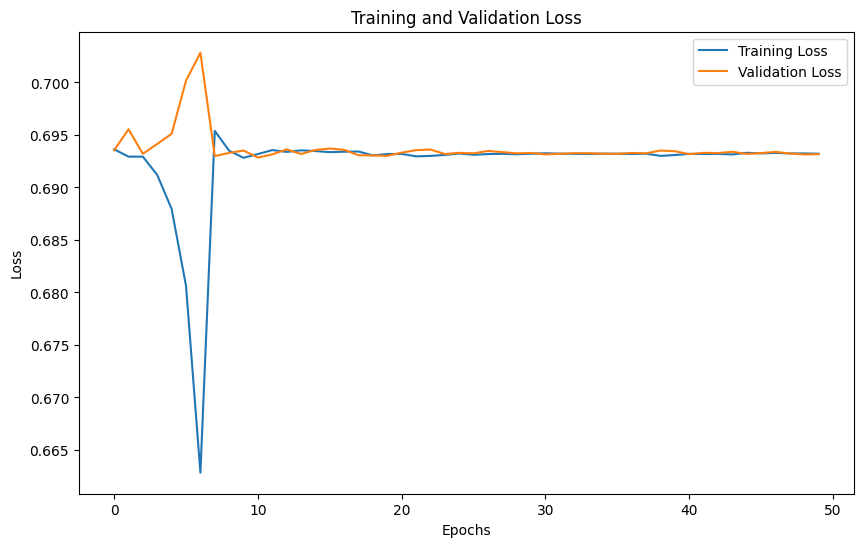

In [71]:
embedding_dim = 100
hidden_size = 128
output_size = 1  # Binary classification
num_layers = 2
dropout_prob = 0.5
learning_rate = 0.001
epochs = 50
patience = 5
batch_size = 32

pytorch_lstm_model = PyTorchLSTM(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    output_size=output_size,
    embedding_matrix=embedding_tensor,
    num_layers=num_layers,
    dropout_prob=dropout_prob
)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(pytorch_lstm_model.parameters(), lr=learning_rate, weight_decay=1e-4)

print("Starting training of PyTorchLSTM model...")
pytorch_train_losses, pytorch_val_losses = train_pytorch_model(
    model=pytorch_lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    patience=patience
)

plot_training_history(pytorch_train_losses, pytorch_val_losses)



Evaluating Custom LSTM Model on Test Set...

Evaluating PyTorchLSTM Model on Test Set...

==================== Test Set Evaluation ====================

Test Performance:
  Test Loss:    0.6928
  Accuracy:     51.33%
  Precision:    51.33%
  Recall:       100.00%
  F1-Score:     67.84%
  Confusion Matrix:
[[  0 730]
 [  0 770]]


Comparison of Custom LSTM and PyTorchLSTM Models on Test Set:
      Metric  Custom LSTM  PyTorch LSTM
0  Test Loss     0.386737      0.692811
1   Accuracy     0.844000      0.513333
2  Precision     0.834165      0.513333
3     Recall     0.868831      1.000000
4   F1-Score     0.851145      0.678414


<ipython-input-72-71ef159c6820>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
<ipython-in

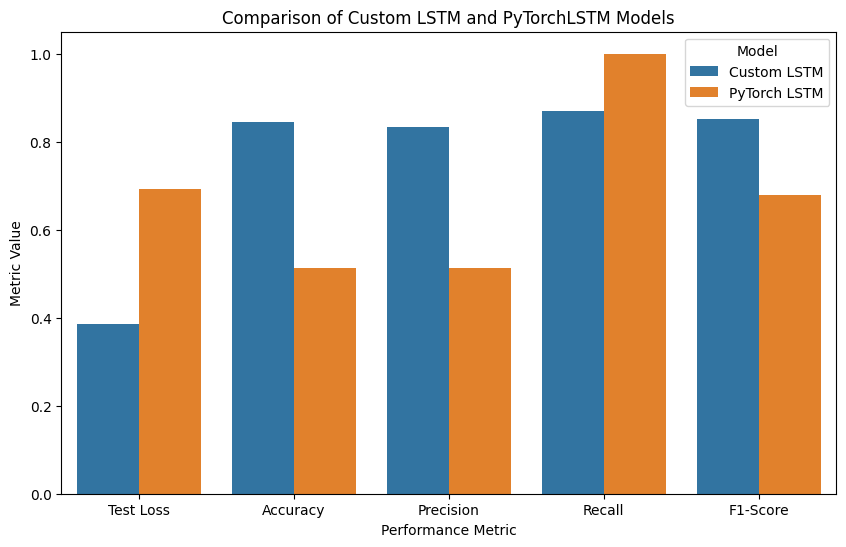

In [72]:
def load_and_evaluate(model, model_path, test_loader, criterion):

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

    test_metrics = evaluate_best_model_on_test_set(
        best_model_path=model_path,
        model=model,
        test_loader=test_loader,
        criterion=criterion
    )

    return test_metrics

print("\nEvaluating PyTorchLSTM Model on Test Set...")
pytorch_test_metrics = load_and_evaluate(
    model=pytorch_lstm_model,
    model_path="pytorch_best_model.pt",
    test_loader=test_loader,
    criterion=criterion
)

import pandas as pd

comparison_df = pd.DataFrame({
    'Metric': ['Test Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Custom LSTM': [
        test_metrics['test_loss'],
        test_metrics['test_accuracy'],
        test_metrics['test_precision'],
        test_metrics['test_recall'],
        test_metrics['test_f1_score']
    ],
    'PyTorch LSTM': [
        pytorch_test_metrics['test_loss'],
        pytorch_test_metrics['test_accuracy'],
        pytorch_test_metrics['test_precision'],
        pytorch_test_metrics['test_recall'],
        pytorch_test_metrics['test_f1_score']
    ]
})

print("\nComparison of Custom LSTM and PyTorchLSTM Models on Test Set:")
print(comparison_df)

import matplotlib.pyplot as plt
import seaborn as sns

melted_df = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=melted_df)
plt.title('Comparison of Custom LSTM and PyTorchLSTM Models')
plt.ylabel('Metric Value')
plt.xlabel('Performance Metric')
plt.legend(title='Model')
plt.show()


In [73]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np

# Step 1: Load the test data
test_file_path = '/content/subset1000_IMDB_Dataset.csv'
test_data = pd.read_csv(test_file_path)

# Predefine tokenizer and other preprocessing utilities (reuse from training)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"[/\-]", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens


MAX_LEN = 150

def pad_sequence_updated(sequences, maxlen):
    return pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Step 2: Preprocess the test data, apply the steps used during training (change according to your implementation)
test_data['tokens'] = test_data['review'].apply(preprocess_text)
test_data['token_indices'] = tokenizer.texts_to_sequences(test_data['tokens'])
padded_test = pad_sequence_updated(test_data['token_indices'], MAX_LEN)

test_tensor = torch.tensor(padded_test, dtype=torch.long)

# Step 3: Load the best-performing model
model_path = 'best_model.pt'
model = SentimentLSTM(input_size, hidden_size, output_size, embedding_tensor)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

class IMDBDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        return {'sequence': sequence}

# Step 4: Predict sentiment for the test reviews
batch_size = 32
test_dataset_eval = IMDBDataset(padded_test)
test_loader = DataLoader(test_dataset_eval, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully.")

predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['sequence']
        outputs = model(inputs)
        preds = torch.round(outputs).squeeze().tolist()
        predictions.extend(preds)

# Step 5: Map predicted class labels to corresponding class names
class_labels = {0: 'negative', 1: 'positive'}

# Step 6: Save predictions to CSV file
df_predictions = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'sentiment': [class_labels[int(p)] for p in predictions]})
df_predictions.to_csv('predictions.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-73-67e4382e4b0a>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

DataLoaders created successfully.
